In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt

# カスタム関数のimport
import importlib
import src.calc_rmse
importlib.reload(src.calc_rmse)
from src.calc_rmse import calc_rmse  # 再読み込み後に再import
from src.calc_tcr import calc_tcr  # 再読み込み後に再import

## ショートカットキーメモ: jupyter notebook の基本的な使い方

| ショートカットキー             | 機能             |
|-------------------------------|------------------|
| Ctrl + Enter                  | セルの実行       |
| Ctrl + /                      | コメントアウト    |
| Ctrl + Shift + minux          | セルの分割       |




# レーダデータのローディング
## loading

In [ ]:
from scipy.io import loadmat
import os

# eventi = 1 # 呼吸なし
eventi = 2 # 呼吸あり <- 基本的にこれを解析して欲しい

subi = 1
# subi = 2
# subi = 3
# subi = 4
# subi = 5

data_dir = os.path.abspath(os.path.join(os.getcwd(), 'data'))
print(data_dir)

radar_data_path = os.path.join(data_dir, f'radarIBI_event{eventi}_sub{subi}.mat')
ibiECG_path = os.path.join(data_dir, f'ibiECG_event{eventi}_sub{subi}.mat')
data = loadmat(radar_data_path)
ibiECG = loadmat(ibiECG_path)


d:\Dropbox\sumi@labKyoto\WorkspaceCl\2025\Intern2_202505GaussProcess\Python\data


In [10]:
radarIBI_time = data['radarIBI']['time']
radarIBI_ibi = data['radarIBI']['ibi']

radarIBI_time = radarIBI_time[0,0].squeeze()
radarIBI_ibi = radarIBI_ibi[0,0].squeeze()

ibiECG_time = ibiECG['ibiECG']['startTime']
ibiECG_ibi = ibiECG['ibiECG']['ibi']
ibiECG_time = ibiECG_time[0,0].squeeze()
ibiECG_ibi = ibiECG_ibi[0,0].squeeze()
print(ibiECG_time.shape)


(179,)


## 前処理1 時間の抽出


In [15]:
### 0 ~ 160 sの全て
# min_time_s = 0
# max_time_s = 160
### 30 ~ 60 s
min_time_s = 30
max_time_s = 90

cut_time_range = np.array([min_time_s, max_time_s])
mask = (radarIBI_time >= cut_time_range[0]) & (radarIBI_time <= cut_time_range[1])
radarIBI_time_cut = radarIBI_time[mask]
radarIBI_ibi_cut = radarIBI_ibi[mask]

mas_ecgk = (ibiECG_time >= cut_time_range[0]) & (ibiECG_time <= cut_time_range[1])
ibiECG_time_cut = ibiECG_time[mas_ecgk]
ibiECG_ibi_cut = ibiECG_ibi[mas_ecgk]

print(ibiECG_time_cut.shape)

(67,)


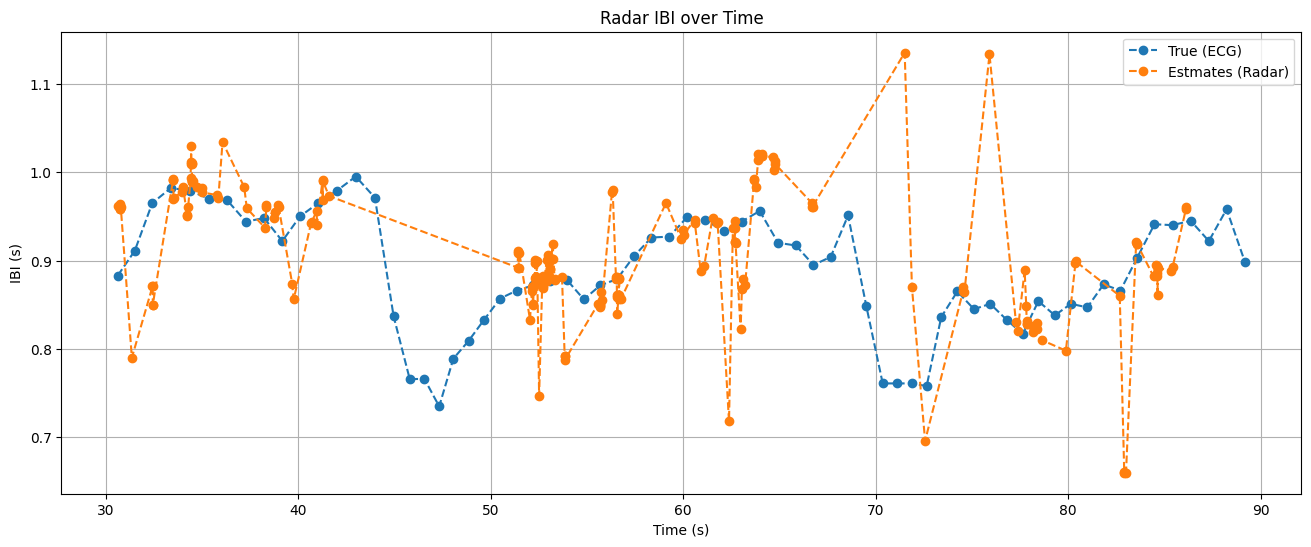

In [40]:
# Show IBI Radar and ECG
this_time = radarIBI_time_cut
this_ibi = radarIBI_ibi_cut


plt.figure(figsize=(16, 6))
plt.plot(ibiECG_time_cut, ibiECG_ibi_cut, '--o', label='True (ECG)')
plt.plot(this_time, this_ibi, '--o', label='Estmates (Radar)')

plt.xlabel('Time (s)')
plt.ylabel('IBI (s)')
plt.title('Radar IBI over Time')
plt.legend()
plt.grid()
# plt.xlim(0, 160)  # x軸の範囲を0から160に設定
plt.show()

# scikit learn

In [17]:
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
from sklearn.gaussian_process.kernels import Matern

y_radar = this_ibi
X_radar = this_time.reshape(-1, 1)

# カーネルの定義（RBF + WhiteKernel + PeriodicKernel）
# カーネルの定義（Matern Kernel + WhiteKernel）
kernel_radar = (
    C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5) +
    WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e1))
)

# kernel_radar = (
#     C(1.0, (1e-3, 1e3)) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5) +
#     WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e1))
# )


# kernel_radar = (
#     C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2)) +
#     WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e1)) +
#     ExpSineSquared(length_scale=1.0, periodicity=3.0, periodicity_bounds=(1.0, 10.0))
# )

# Gaussian Process Regressorの初期化
gp_radar = GaussianProcessRegressor(kernel=kernel_radar, n_restarts_optimizer=10)

# モデルの学習
gp_radar.fit(X_radar, y_radar)




GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1e-05),
                         n_restarts_optimizer=10)

## モデルに基づいて予測(補間)

In [ ]:
x_time_min = X_radar.min()
x_time_max = X_radar.max()

# 予測のための新しい時間データを生成
# 0.5秒刻みで予測
X_radar_pred_sklearn = np.arange(x_time_min, x_time_max + 1, 0.5).reshape(-1, 1)
# 0.01秒刻みで予測
# X_radar_pred_sklearn = np.arange(x_time_min, x_time_max + 1, 0.01).reshape(-1, 1)


# 予測の実行 (平均と標準偏差を予測)
y_radar_pred_sklearn, sigma_radar_sklearn = gp_radar.predict(X_radar_pred_sklearn, return_std=True)


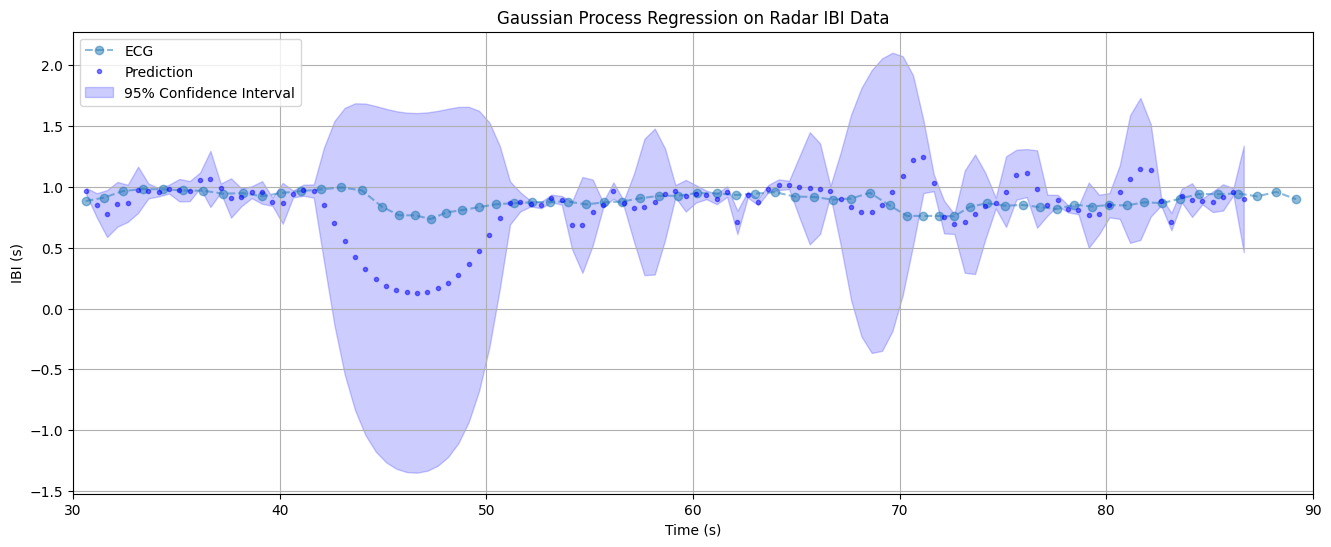

In [ ]:
# プロット
# x軸の範囲を設定
XLim = np.array([min_time_s, max_time_s])


transparent_alpha = 0.5
plt.figure(figsize=(16, 6))
plt.plot(ibiECG_time_cut, ibiECG_ibi_cut, '--o', label='ECG', alpha=transparent_alpha)
# plt.plot(X_radar, y_radar, 'r.', markersize=3, label='Observed Data', alpha=transparent_alpha)
plt.plot(X_radar_pred_sklearn, y_radar_pred_sklearn, 'b.', label='Prediction', alpha=transparent_alpha)
plt.fill_between(
    X_radar_pred_sklearn.ravel(),
    y_radar_pred_sklearn - 1.96 * sigma_radar_sklearn,
    y_radar_pred_sklearn + 1.96 * sigma_radar_sklearn,
    alpha=0.2,
    color='blue',
    label='95% Confidence Interval'
)
plt.xlabel('Time (s)')
plt.ylabel('IBI (s)')
plt.legend()
plt.title('Gaussian Process Regression on Radar IBI Data')
plt.grid()
plt.xlim(XLim)  # y軸の範囲を設定
plt.show()

In [ ]:
# 精度評価(RMSEとTCR)
# RMSEの計算
radar_est_time = X_radar_pred_sklearn.ravel()
radar_est_ibi = y_radar_pred_sklearn.ravel()
ecg_time = ibiECG_time_cut.ravel()
ecg_ibi = ibiECG_ibi_cut.ravel()
[rmse, IBI_diff] = calc_rmse(radar_est_time, radar_est_ibi, ecg_time, ecg_ibi)
print(f"RMSE: {rmse*1e3:.2f} ms")
# TCRの計算
TCR_dt = 1
# ERROR_TIME = 50*1e-3
ERROR_TIME = 15*1e-3
tcr = calc_tcr(radar_est_time, radar_est_ibi, ecg_time, ecg_ibi, TCR_dt, ERROR_TIME)
print(f"TCR: {tcr:.2f} %")


RMSE: 251.70 ms
TCR: 29.31 %


## GPの推定の標準偏差が大きい外れ値を除去
sigma_radar_sklearnがoutlier_ibi_thre_s以下のindexを取得

(22,)


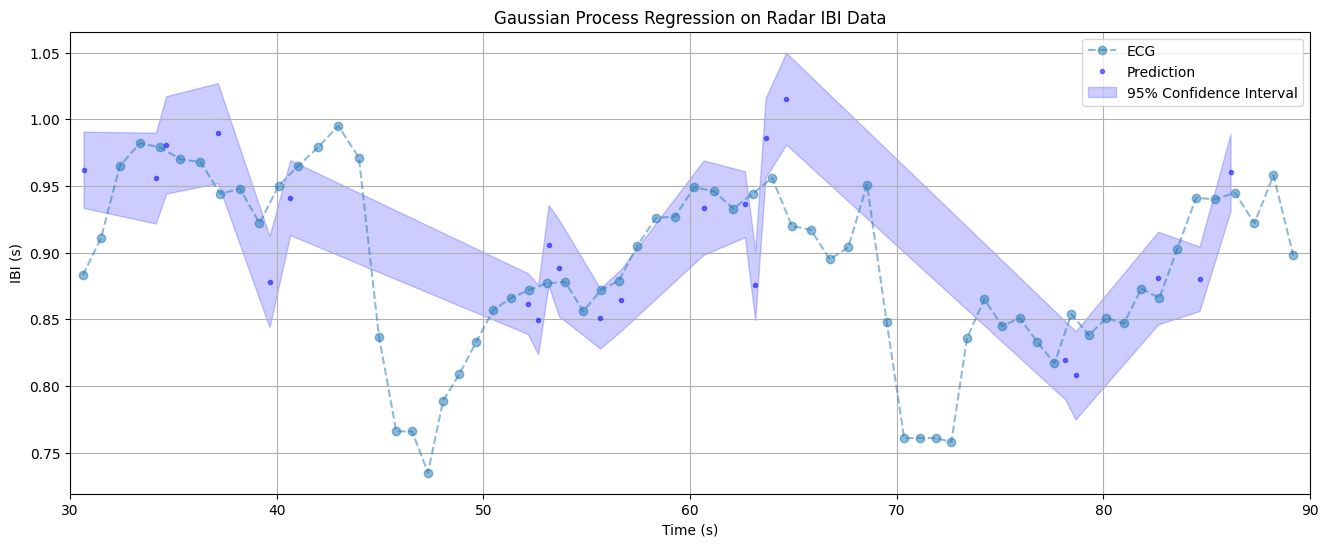

In [37]:
outlier_ibi_thre_s = 20*1e-3 # 1 sigmaが20 ms 以下を削除
valid_idx = np.where(sigma_radar_sklearn <= outlier_ibi_thre_s)[0]
X_radar_pred_sklearn_cut = X_radar_pred_sklearn[valid_idx]
y_radar_pred_sklearn_cut = y_radar_pred_sklearn[valid_idx]
sigma_radar_sklearn_cut = sigma_radar_sklearn[valid_idx]
print(sigma_radar_sklearn_cut.shape)

# x軸の範囲を設定
XLim = np.array([min_time_s, max_time_s])
# XLim = np.array([0, 40])
# XLim = np.array([40, 80])
# XLim = np.array([80, 120])

# プロット
transparent_alpha = 0.5
plt.figure(figsize=(16, 6))
plt.plot(ibiECG_time_cut, ibiECG_ibi_cut, '--o', label='ECG', alpha=transparent_alpha)
# plt.plot(X_radar, y_radar, 'r.', markersize=3, label='Observed Data', alpha=transparent_alpha)
plt.plot(X_radar_pred_sklearn_cut, y_radar_pred_sklearn_cut, 'b.', label='Prediction', alpha=transparent_alpha)
plt.fill_between(


    
    X_radar_pred_sklearn_cut.ravel(),
    y_radar_pred_sklearn_cut - 1.96 * sigma_radar_sklearn_cut,
    y_radar_pred_sklearn_cut + 1.96 * sigma_radar_sklearn_cut,
    alpha=0.2,
    color='blue',
    label='95% Confidence Interval'
)
plt.xlabel('Time (s)')
plt.ylabel('IBI (s)')
plt.legend()
plt.title('Gaussian Process Regression on Radar IBI Data')
plt.grid()
plt.xlim(XLim)  # y軸の範囲を設定
plt.show()

In [38]:
# 精度評価
# RMSEの計算
radar_est_time = X_radar_pred_sklearn_cut.ravel()
radar_est_ibi = y_radar_pred_sklearn_cut.ravel()
ecg_time = ibiECG_time_cut.ravel()
ecg_ibi = ibiECG_ibi_cut.ravel()
[rmse, IBI_diff] = calc_rmse(radar_est_time, radar_est_ibi, ecg_time, ecg_ibi)
print(f"RMSE: {rmse*1e3:.2f} ms")
# TCR
TCR_dt = 1
# ERROR_TIME = 50*1e-3
ERROR_TIME = 15*1e-3
tcr = calc_tcr(radar_est_time, radar_est_ibi, ecg_time, ecg_ibi, TCR_dt, ERROR_TIME)
print(f"TCR: {tcr:.2f} %")

RMSE: 52.92 ms
TCR: 10.34 %


(22,)

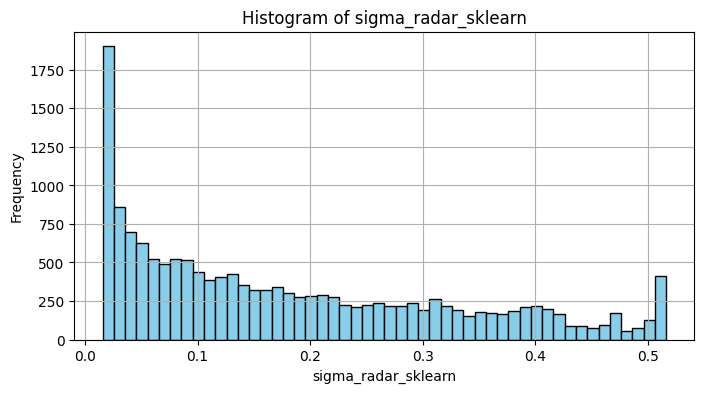

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(sigma_radar_sklearn, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('sigma_radar_sklearn')
plt.ylabel('Frequency')
plt.title('Histogram of sigma_radar_sklearn')
plt.grid(True)
plt.show()


# GPy

In [41]:
X = np.linspace(0, 10, 50)[:, None]
y = np.sin(X) + np.random.normal(0, 0.5, X.shape)
y = this_ibi.reshape(-1, 1)
X = this_time.reshape(-1, 1)

print(X.shape)
print(y.shape)

(204, 1)
(204, 1)


In [ ]:
import GPy
# カーネルの定義
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=5.0)

# Student-t 分布を考慮したガウス過程モデル
# GPy では標準で Student-t 分布をサポートしていないため、ロバストな尤度を使用
model = GPy.models.GPRegression(X, y, kernel)
# model.likelihood.variance.fix(1.0)  # 外れ値に強い設定

# モデルの最適化
model.optimize(messages=True)

## モデルに基づいて予測(補間)

In [55]:
# 予測
x_time_min = X_radar.min()
x_time_max = X_radar.max()

# 0.5秒刻みで予測
X_pred_gpy = np.arange(x_time_min, x_time_max + 1, 0.5).reshape(-1, 1)
# 0.01秒刻みで予測
# X_pred_gpy = np.arange(x_time_min, x_time_max + 1, 0.01).reshape(-1, 1)

# 予測(補間)
y_pred_gpy, y_var_gpy = model.predict(X_pred_gpy)

print(X_pred_gpy.shape)
print(y_pred_gpy.shape)

(113, 1)
(113, 1)


(57, 1)
(113, 1)


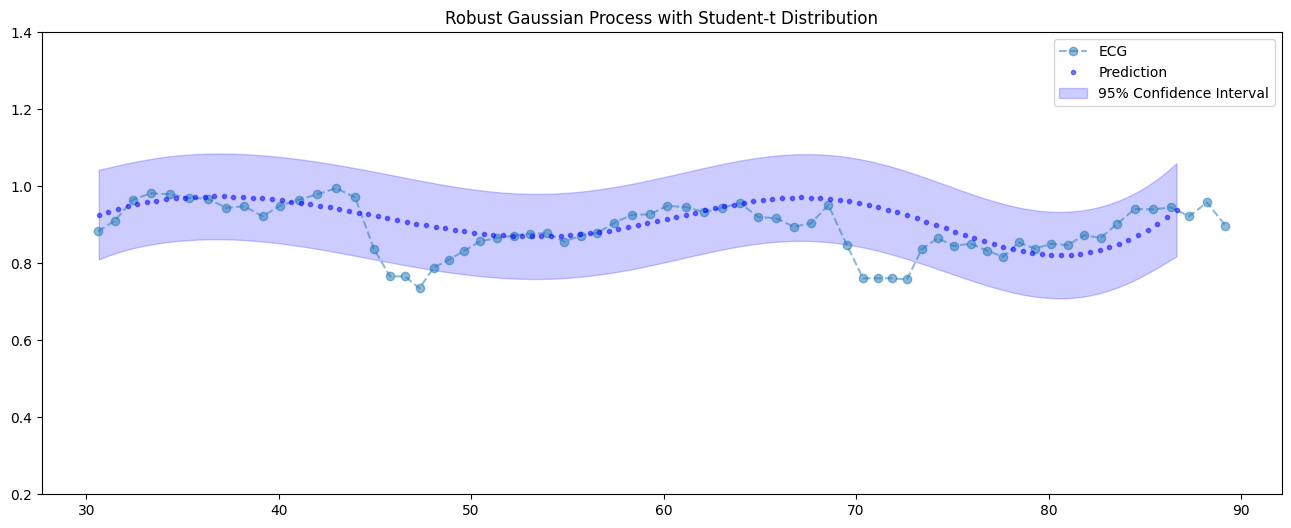

In [ ]:
# プロット
transparent_alpha=0.5  # 透明度の設定


plt.figure(figsize=(16, 6))
plt.plot(ibiECG_time_cut, ibiECG_ibi_cut, '--o', label='ECG', alpha=transparent_alpha)
# plt.plot(X, y, 'r.', label='Observed Data', alpha=transparent_alpha)
plt.plot(X_pred_gpy, y_pred_gpy, 'b.', label='Prediction', alpha=transparent_alpha)
plt.fill_between(
    X_pred_gpy.flatten(),
    (y_pred_gpy - 1.96 * np.sqrt(y_var_gpy)).flatten(),
    (y_pred_gpy + 1.96 * np.sqrt(y_var_gpy)).flatten(),
    color='blue',
    alpha=0.2,
    label='95% Confidence Interval'
)
plt.ylim(0.2, 1.4)  # y軸の範囲を設定
plt.legend()
plt.title('Robust Gaussian Process with Student-t Distribution')
plt.show()

In [58]:

# 精度評価
# RMSEの計算
radar_est_time = X_pred_gpy
radar_est_ibi = y_pred_gpy
ecg_time = ibiECG_time_cut
ecg_ibi = ibiECG_ibi_cut
[rmse, IBI_diff] = calc_rmse(radar_est_time, radar_est_ibi, ecg_time, ecg_ibi)
print(f"RMSE: {rmse*1e3:.2f} ms")
# TCRの計算
TCR_dt = 1
# ERROR_TIME = 50*1e-3
ERROR_TIME = 15*1e-3
tcr = calc_tcr(radar_est_time, radar_est_ibi, ecg_time, ecg_ibi, TCR_dt, ERROR_TIME)
print(f"TCR: {tcr:.2f} %")


RMSE: 69.46 ms
TCR: 32.76 %


# miscellaneous

In [69]:
sigma_radar_sklearn

array([0.02082555, 0.02119593, 0.02256592, ..., 0.3795963 , 0.38190249,
       0.38417577])

In [40]:
X_radar_pred_sklearn[0]


array([40.007])

In [39]:
y_radar_pred_sklearn[0,0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed